In [34]:
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_management import load_tsv
from data_utils import string_encoding_to_datetime, select_by_dict, print_unique_values
from datetime import datetime
plt.rcParams['figure.figsize'] = 20, 16

In [2]:
nights_spent = load_tsv("tour_occ_nim.tsv", decode=True)
print_unique_values(nights_spent)
sub = select_by_dict(nights_spent, {
    "c_resid": "Foreign country",
    "unit": "Number",
    "nace_r2": "Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks"
})

c_resid
	Foreign country
	Reporting country
	Total
unit
	Number
	Percentage change compared to same period in previous year
nace_r2
	Hotels and similar accommodation
	Hotels; holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Holiday and other short-stay accommodation
	Holiday and other short-stay accommodation; camping grounds, recreational vehicle parks and trailer parks
	Camping grounds, recreational vehicle parks and trailer parks
geo
	Albania
	Austria
	Belgium
	Bulgaria
	Switzerland
	Cyprus
	Czechia
	Germany (until 1990 former territory of the FRG)
	Denmark
	Euro area (EA11-2000, EA12-2006, EA13-2007, EA15-2008, EA16-2010, EA17-2013, EA18-2014, EA19)
	Estonia
	Greece
	Spain
	European Union - 27 countries (2007-2013)
	European Union - 28 countries
	Finland
	France
	Croatia
	Hungary
	Ireland
	Iceland
	Italy
	Liechtenstein
	Lithuania
	Luxembourg
	Latvia
	Montenegro
	North Macedonia
	Malta
	Netherlands
	Norway
	Poland
	Portugal
	

In [3]:
spain = select_by_dict(sub, {
    "geo": "Spain"
})
spain = spain[~spain["value"].isnull()]
spain["time"] = spain["time"].apply(string_encoding_to_datetime)
spain = spain.set_index("time")
# spain.index = spain.index.astype(np.int64)
spain

,value
time,
2019-08-01,40674210.0
2019-07-01,39000064.0
2019-06-01,32958613.0
2019-05-01,28139577.0
2019-04-01,21707231.0
...,...
1990-05-01,6954375.0
1990-04-01,5261825.0
1990-03-01,4150458.0


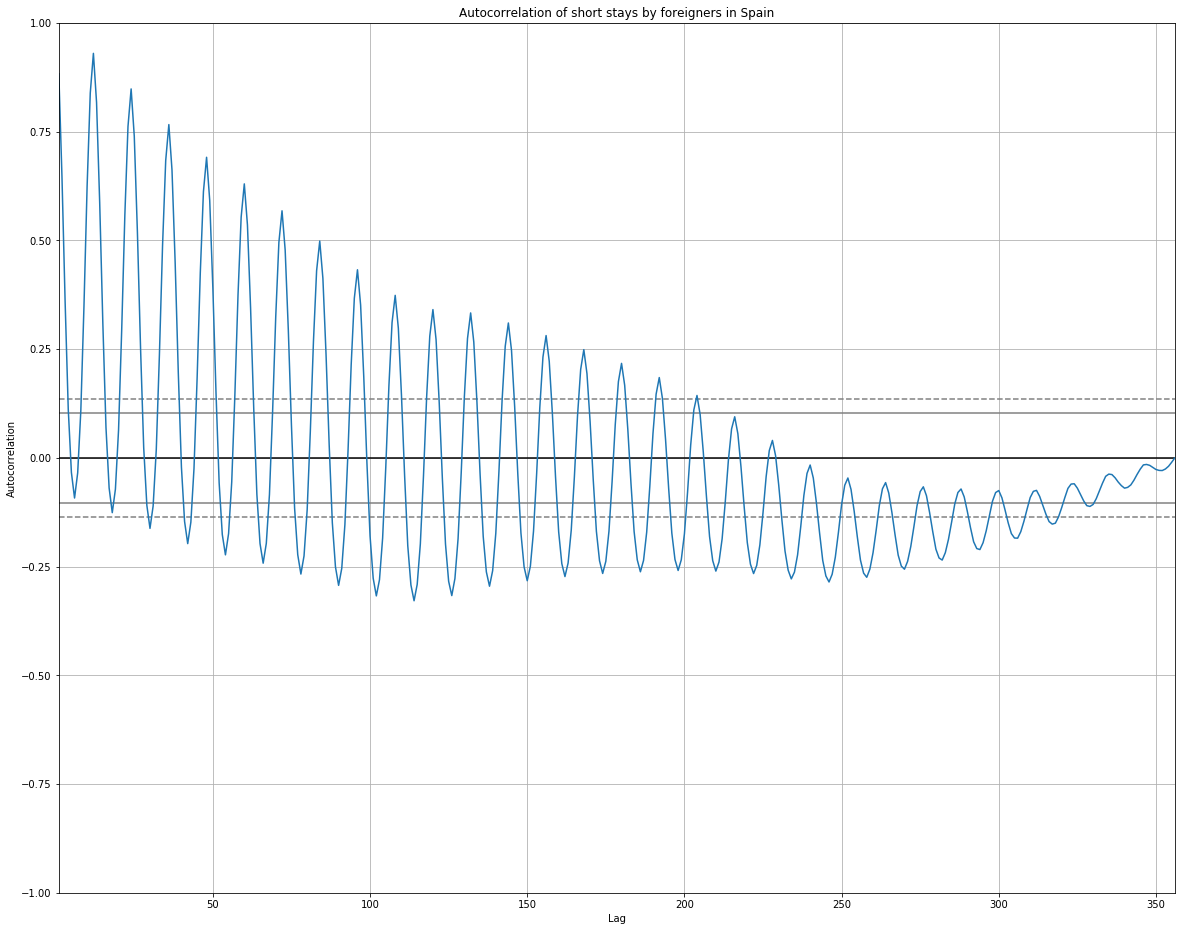

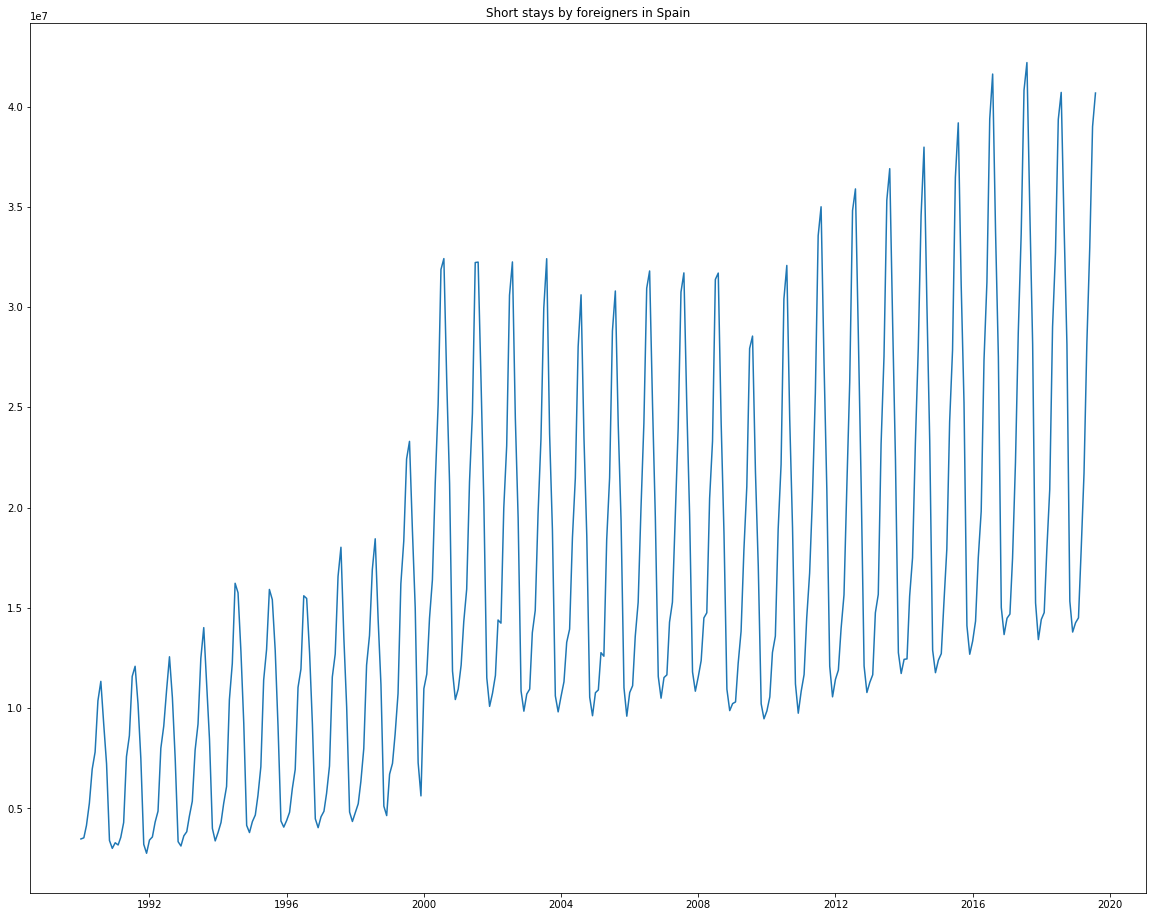

In [35]:
"""
Autocorrelation shows extremely high autocorrelation, especially with the previous year
General trends in the data makes it more the autocorrelation weaker with a higher time lag
Note the lag is in months
The autocorrelation plot shows 3 distinct distinct regions that correspond to changing trends in the original data
"""
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(spain)
plt.title("Autocorrelation of short stays by foreigners in Spain")
plt.show()
plt.title("Short stays by foreigners in Spain")
plt.plot(spain)
plt.show()

In [5]:
from statsmodels.tsa.arima_model import ARIMA

In [6]:
spain.sort_index(inplace=True)

In [25]:
model = ARIMA(spain.iloc[:-24, :], order=(12,1,0))
model_fit = model.fit(disp=0)

C:\Users\tonym\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\tonym\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\tonym\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\tonym\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


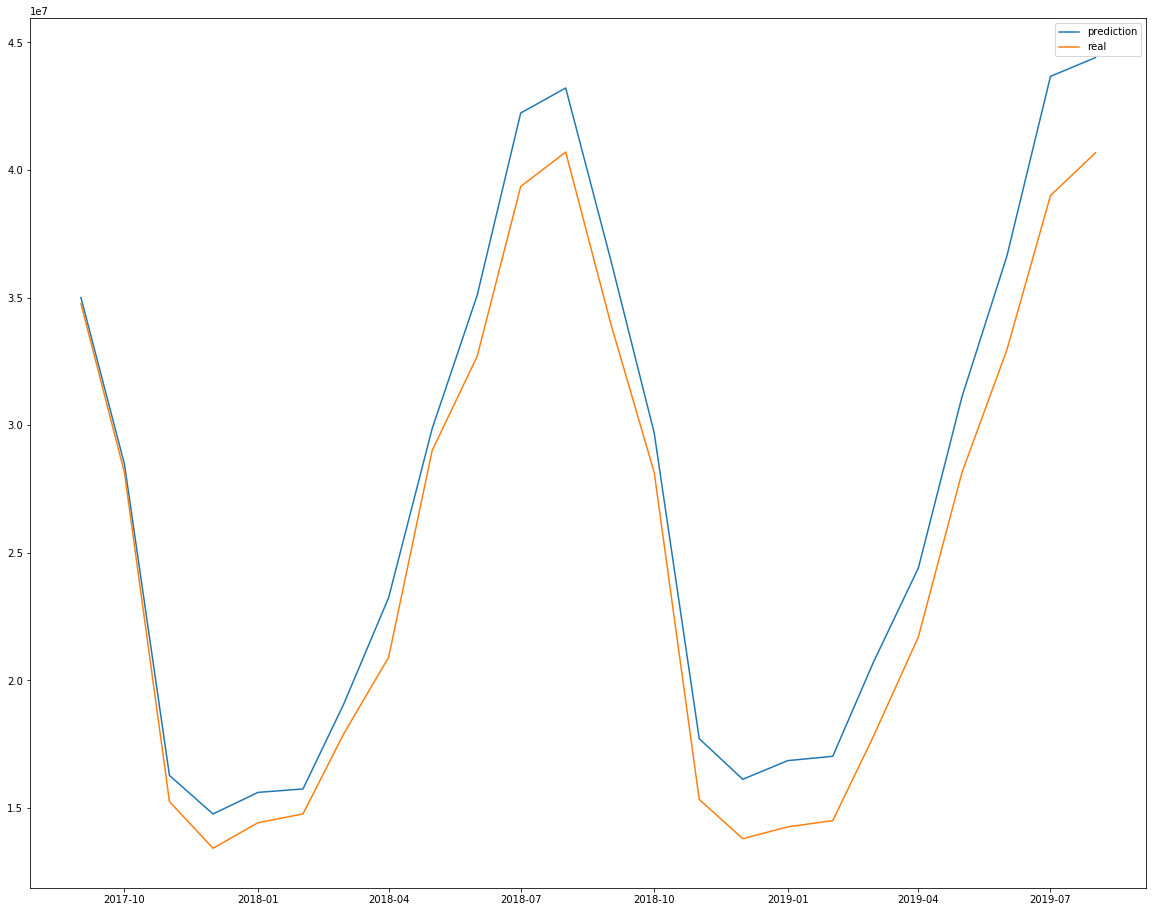

In [36]:
"""
The general monthly trend of the data can be approximated fairly easy using an ARIMA model
"""
plt.plot(spain["value"].tail(24).index, model_fit.forecast(24)[0], label="prediction")
plt.plot(spain["value"].tail(24), label="real")
plt.legend()
plt.show()

In [50]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  331
Model:                ARIMA(12, 1, 0)   Log Likelihood               -4984.686
Method:                       css-mle   S.D. of innovations         776715.543
Date:                Tue, 17 Dec 2019   AIC                           9997.373
Time:                        17:21:26   BIC                          10050.602
Sample:                    02-01-1990   HQIC                         10018.603
                         - 08-01-2017                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const            1.17e+05     43.765   2672.543      0.000    1.17e+05    1.17e+05
ar.L1.D.value     -0.0715   1.04e-05  -6876.436      0.000      -0.072      -0.072
ar.L2.D.value     -0.0905   1.84e-05

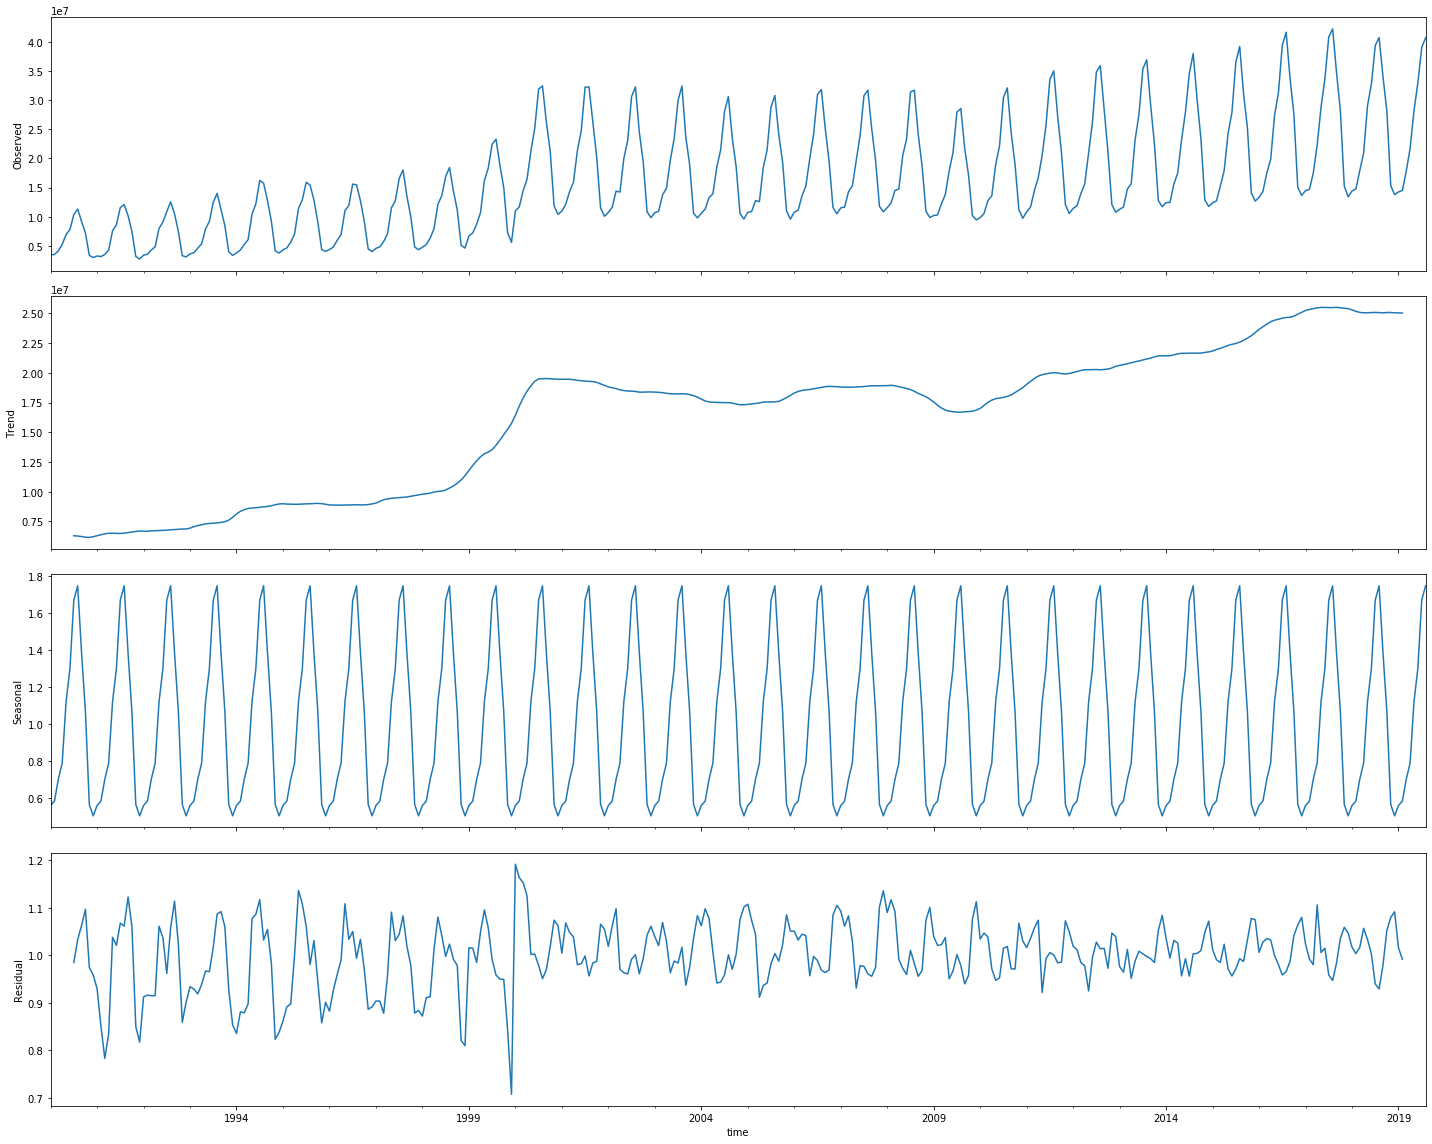

In [37]:
"""
Decomposing the signal into its components, it's clear that a very noticible, repetitive seasonal trend emerges
This trend is also accompanied by a a general increase in short-term stays overall
"""

from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(spain["value"], model='multiplicative', freq=12)
result.plot()
plt.show()